# Estimando parâmetros de modelos EDO
Um dos problemas centrais da modelagem é como descobrir os valores "corretos" dos parâmetros do modelo. Já exploramos metodologias de otimização para este fim. Neste notebook vamos tratar este problema como um problema de inferência. Para isso vamos assumir que nossos parâmetros são variáveis aleatórias. Seja $\theta$ o conjunto de parâmetros de nosso modelo e $p(\theta)$ a distribuição de probabilidade conjunta destes parâmetros. seja $\mathcal{M}$ o nosso modelo, e $\phi$ o conjunto das saídas deste modelo: $\{x_i(t)\}_{i=1}^{n}$, onde n é a dimensão do nosso modelo. 
$$\phi=\mathcal{M}(\theta)$$

Assumir que os parametros $\theta$ do modelo são variáveis aleatórias implica que as saídas do modelo também passam a possuir uma distribuição de probabilidade. Vamos resolver este problema de inferência por meio de inferência Bayesiana. Vamos começar por atribuir uma distribuição *a priori* para $\theta$, que chamaremos  de $p(\theta)$ que induz uma distribuição sobre as saídas do modelo, $p(\phi)$. Usaremos a  fórmula de Bayes para estimar simultaneamente a distribuição posterior de $\theta$, $\pi(\theta)$ e de $\phi$, $\pi(\phi)$.

$$\pi(\theta|dados)\propto p(dados|\theta)p(\theta)$$

Para estimar este modelo precisaremos lançar mão de métodos numéricos como algoritmos de Markov-chain Monte-Carlo (MCMC).
### Para saber mais
1. [Coelho et al. (2011) A Bayesian Framework for Parameter Estimation in Dynamical Models](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0019616)

Nesta aula, vamos utilizar a biblioteca PyMC3 para fazer a estimação de parâmetros de um modelo SIR
Para executar este notebook vamos precisar instalar o pymc3
```
pip install pymc3
```

In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

O primeiro passo é implementar o nosso modelo 

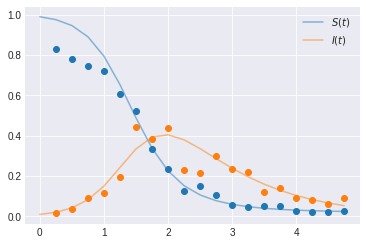

In [2]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

times = np.arange(0, 5, 0.25)

beta,gamma = 4,1.0
# Gerando curvas simuladas
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Simulando dados  Assumindo uma distribuição log-normal com média igual às séries simuladas
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$');
plt.legend();


Abaixo deifinimos nosso modelo usando a classe `DifferentialEquation` do PyMC3

In [3]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

Agora precisamos definir as distribuições *a priori* dos parâmetros do modelo e a verossimilhança de $\phi$.

In [8]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    gam = pm.Lognormal('gamma', pm.math.log(2), 2)
    beta = pm.Deterministic('beta', gam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, gam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(2000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, R0, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1812 seconds.


In [14]:
data = az.from_pymc3(trace=trace)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

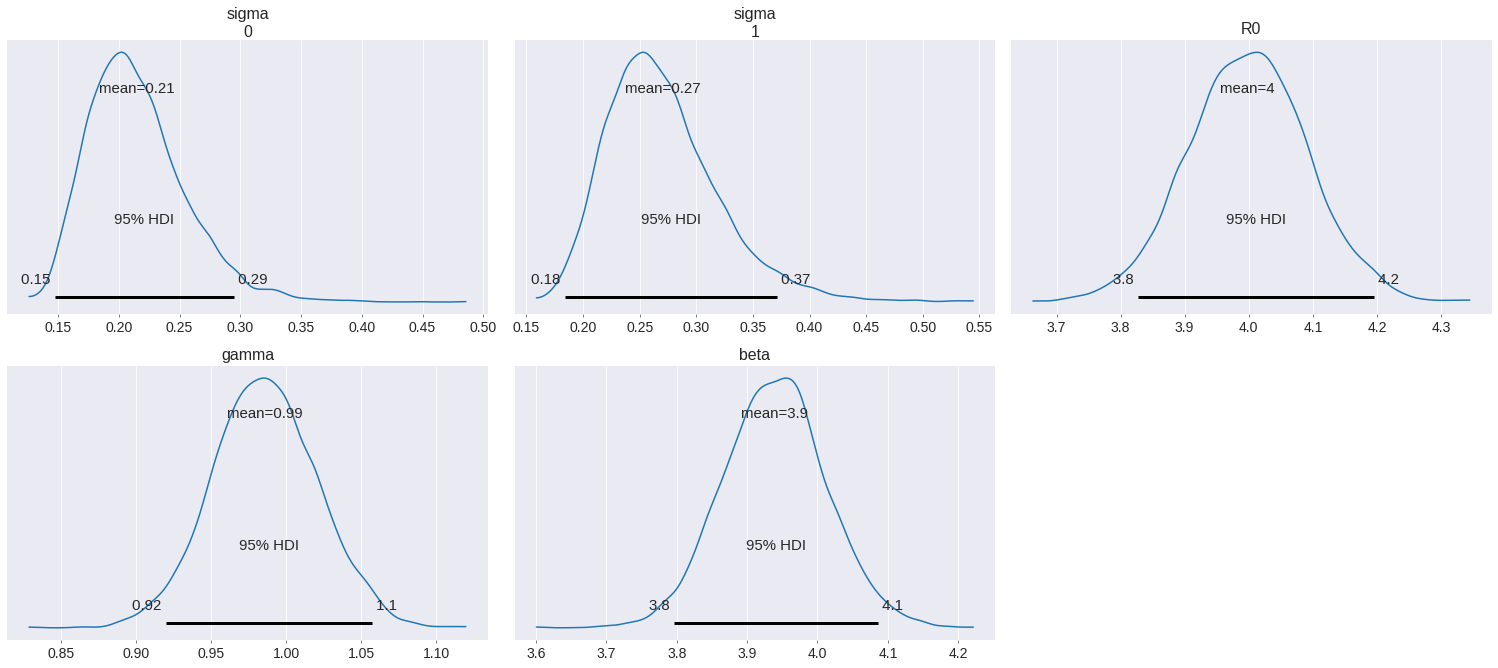

In [16]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy  1.16.6
pymc3  3.9.3
theano 1.0.5
arviz  0.10.0
last updated: Mon Oct 12 2020 

CPython 3.7.3
IPython 5.8.0
watermark 2.0.2
